# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "CF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = vaep.nb.get_params(args, globals=globals())
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'CF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                                   
Sample_175  F8WAD8;Q9P0K1;Q9P0K1-2;Q9P0K1-3;Q9P0K1-4;Q9P0K1-5   19.700
Sample_159  M0QZI8;Q9UBX7;Q9UBX7-1;Q9UBX7-3;Q9UBX7-4            15.815
Sample_013  E9PCD7;Q9Y2E5                                       15.222
Sample_053  F8WE04;P04792                                       14.073
Sample_089  P18669                                              16.333
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by CF: runs/alzheimer_study/preds/pred_real_na_CF.csv


Sample ID   protein groups 
Sample_145  A0A0C4DH31        16.315
Sample_108  Q9Y281;Q9Y281-3   12.225
Sample_155  P31150            15.829
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.764
            A0A075B6Q5                 13.212
            A0A075B6R2                 12.838
            A0A075B6S5                 11.084
            A0A087WSY4                 13.285
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   13.309
            Q9UI40;Q9UI40-2            12.271
            Q9UIW2                     13.741
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.788
            Q9UP79                     12.576
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.082,15.050,16.842,19.863,16.052,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.584,19.067,...,15.528,15.576,14.045,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.569,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.022,17.705,17.039,14.776,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.640,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.580,15.345,17.084,18.708,14.249,19.433,12.675,11.433
Sample_207,15.739,16.877,15.469,16.898,15.046,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,12.764,...,16.012,15.178,13.691,15.050,16.842,19.863,14.132,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,11.232,19.067,16.188,...,15.528,15.576,12.956,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,12.675,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,12.000,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,13.291,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,13.125,15.345,17.084,18.708,14.249,19.433,11.855,11.414
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 364.50it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  3.72it/s]

100%|██████████| 2/2 [00:00<00:00,  3.72it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.61it/s]

100%|██████████| 3/3 [00:00<00:00,  3.45it/s]

100%|██████████| 3/3 [00:00<00:00,  3.62it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  3.88it/s]

 75%|███████▌  | 3/4 [00:01<00:00,  2.52it/s]

100%|██████████| 4/4 [00:01<00:00,  2.17it/s]

100%|██████████| 4/4 [00:01<00:00,  2.37it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.41it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.02it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.48it/s]

100%|██████████| 5/5 [00:01<00:00,  3.03it/s]

100%|██████████| 5/5 [00:01<00:00,  3.37it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:01,  3.72it/s]

 50%|█████     | 3/6 [00:00<00:01,  2.93it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.76it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.53it/s]

100%|██████████| 6/6 [00:02<00:00,  2.60it/s]

100%|██████████| 6/6 [00:02<00:00,  2.73it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  3.45it/s]

 43%|████▎     | 3/7 [00:01<00:01,  2.22it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.00it/s]

 71%|███████▏  | 5/7 [00:02<00:00,  2.02it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.15it/s]

100%|██████████| 7/7 [00:03<00:00,  1.97it/s]

100%|██████████| 7/7 [00:03<00:00,  2.10it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  4.06it/s]

 38%|███▊      | 3/8 [00:00<00:01,  2.97it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.76it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.70it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.85it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.26it/s]

100%|██████████| 8/8 [00:03<00:00,  1.97it/s]

100%|██████████| 8/8 [00:03<00:00,  2.39it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.04it/s]

 33%|███▎      | 3/9 [00:01<00:02,  2.74it/s]

 44%|████▍     | 4/9 [00:01<00:02,  2.33it/s]

 56%|█████▌    | 5/9 [00:02<00:01,  2.14it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.03it/s]

 78%|███████▊  | 7/9 [00:03<00:00,  2.12it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  1.95it/s]

100%|██████████| 9/9 [00:04<00:00,  1.91it/s]

100%|██████████| 9/9 [00:04<00:00,  2.13it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.03it/s]

 30%|███       | 3/10 [00:01<00:02,  2.48it/s]

 40%|████      | 4/10 [00:01<00:02,  2.30it/s]

 50%|█████     | 5/10 [00:02<00:02,  2.17it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.19it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.42it/s]

 80%|████████  | 8/10 [00:03<00:00,  2.52it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.51it/s]

100%|██████████| 10/10 [00:04<00:00,  2.58it/s]

100%|██████████| 10/10 [00:04<00:00,  2.49it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  6.85it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.36it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.63it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.40it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.24it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.37it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  2.48it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.56it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.30it/s]

100%|██████████| 11/11 [00:04<00:00,  2.01it/s]

100%|██████████| 11/11 [00:04<00:00,  2.40it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.11it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.12it/s]

 33%|███▎      | 4/12 [00:01<00:03,  2.60it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.35it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.31it/s]

 58%|█████▊    | 7/12 [00:02<00:02,  2.37it/s]

 67%|██████▋   | 8/12 [00:03<00:01,  2.15it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.11it/s]

 83%|████████▎ | 10/12 [00:04<00:01,  1.90it/s]

 92%|█████████▏| 11/12 [00:05<00:00,  1.74it/s]

100%|██████████| 12/12 [00:05<00:00,  1.70it/s]

100%|██████████| 12/12 [00:05<00:00,  2.09it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  5.12it/s]

 23%|██▎       | 3/13 [00:00<00:03,  2.89it/s]

 31%|███       | 4/13 [00:01<00:03,  2.52it/s]

 38%|███▊      | 5/13 [00:02<00:03,  2.00it/s]

 46%|████▌     | 6/13 [00:02<00:03,  1.84it/s]

 54%|█████▍    | 7/13 [00:03<00:03,  1.75it/s]

 62%|██████▏   | 8/13 [00:04<00:02,  1.69it/s]

 69%|██████▉   | 9/13 [00:04<00:02,  1.79it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  1.92it/s]

 85%|████████▍ | 11/13 [00:05<00:01,  1.87it/s]

 92%|█████████▏| 12/13 [00:06<00:00,  1.81it/s]

100%|██████████| 13/13 [00:06<00:00,  1.73it/s]

100%|██████████| 13/13 [00:06<00:00,  1.93it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.29it/s]

 21%|██▏       | 3/14 [00:01<00:04,  2.29it/s]

 29%|██▊       | 4/14 [00:01<00:04,  2.05it/s]

 36%|███▌      | 5/14 [00:02<00:04,  2.16it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.25it/s]

 50%|█████     | 7/14 [00:03<00:03,  2.30it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.29it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.27it/s]

 71%|███████▏  | 10/14 [00:04<00:01,  2.29it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.48it/s]

 86%|████████▌ | 12/14 [00:05<00:00,  2.35it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.39it/s]

100%|██████████| 14/14 [00:06<00:00,  2.28it/s]

100%|██████████| 14/14 [00:06<00:00,  2.31it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.04it/s]

 20%|██        | 3/15 [00:00<00:03,  3.11it/s]

 27%|██▋       | 4/15 [00:01<00:04,  2.51it/s]

 33%|███▎      | 5/15 [00:01<00:04,  2.23it/s]

 40%|████      | 6/15 [00:02<00:04,  2.23it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.17it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  2.09it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.20it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  2.16it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.26it/s]

 80%|████████  | 12/15 [00:05<00:01,  2.24it/s]

 87%|████████▋ | 13/15 [00:05<00:00,  2.20it/s]

 93%|█████████▎| 14/15 [00:06<00:00,  2.23it/s]

100%|██████████| 15/15 [00:06<00:00,  2.09it/s]

100%|██████████| 15/15 [00:06<00:00,  2.26it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.006      0.075 0.032          0.706 0.393       0.109   
2             0.006 0.005      0.086 0.024          0.661 0.100       0.563   
3             0.006 0.005      0.065 0.026          0.747 0.093       0.697   
4             0.007 0.006      0.074 0.032          0.728 0.093       0.713   
5             0.006 0.005      0.072 0.025          0.783 0.086       0.747   
6             0.006 0.006      0.070 0.030          0.784 0.097       0.748   
7             0.007 0.008      0.080 0.041          0.790 0.102       0.747   
8             0.006 0.005      0.077 0.031          0.801 0.080       0.820   
9             0.005 0.003      0.062 0.023          0.806 0.081       0.805   
10            0.009 0.007      0.090 0.031          0.803 0.083       0.805   
11            0.007 0.007      0.085 0.041          0.796 0.083       0.804   
12            0.006 0.004      0.074 0.038          0.791 0.081       0.803   
13            0.006 0.004      0.065 0.033          0.789 0.089       0.803   
14            0.006 0.005      0.069 0.028          0.790 0.090       0.803   
15            0.007 0.006      0.081 0.032          0.787 0.089       0.796   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.087   0.181 0.134                  0.547 0.042        0.855   
2          0.106   0.601 0.082                  0.673 0.060        0.730   
3          0.107   0.715 0.080                  0.759 0.065        0.843   
4          0.109   0.715 0.084                  0.757 0.069        0.841   
5          0.129   0.756 0.085                  0.795 0.067        0.846   
6          0.107   0.760 0.082                  0.796 0.068        0.864   
7          0.110   0.762 0.085                  0.799 0.070        0.872   
8          0.098   0.806 0.069                  0.834 0.059        0.903   
9          0.103   0.801 0.071                  0.830 0.060        0.900   
10         0.103   0.800 0.072                  0.829 0.061        0.900   
11         0.105   0.796 0.073                  0.825 0.062        0.899   
12         0.106   0.793 0.075                  0.823 0.064        0.899   
13         0.100   0.791 0.075                  0.821 0.063        0.904   
14         0.104   0.791 0.075                  0.821 0.064        0.901   
15         0.099   0.787 0.073                  0.817 0.062        0.900   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.062                  0.829 0.087        210.000 0.000  
2          0.073                  0.663 0.089        210.000 0.000  
3          0.070                  0.810 0.092        210.000 0.000  
4          0.069                  0.809 0.088        210.000 0.000  
5          0.066                  0.810 0.085        210.000 0.000  
6          0.064                  0.853 0.072        210.000 0.000  
7          0.062                  0.862 0.069        210.000 0.000  
8          0.050                  0.892 0.050        210.000 0.000  
9          0.051                  0.887 0.053        210.000 0.000  
10         0.051                  0.887 0.053        210.000 0.000  
11         0.051                  0.886 0.054        210.000 0.000  
12         0.051                  0.885 0.054        210.000 0.000  
13         0.051                  0.895 0.051        210.000 0.000  
14         0.051                  0.892 0.052        210.000 0.000  
15         0.050                  0.891 0.050 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 393.39it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  2.87it/s]

100%|██████████| 2/2 [00:00<00:00,  2.85it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  3.59it/s]

100%|██████████| 3/3 [00:01<00:00,  2.44it/s]

100%|██████████| 3/3 [00:01<00:00,  2.59it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.25it/s]

 75%|███████▌  | 3/4 [00:01<00:00,  2.37it/s]

100%|██████████| 4/4 [00:01<00:00,  2.13it/s]

100%|██████████| 4/4 [00:01<00:00,  2.35it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:01,  2.68it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.98it/s]

 80%|████████  | 4/5 [00:02<00:00,  1.66it/s]

100%|██████████| 5/5 [00:02<00:00,  1.59it/s]

100%|██████████| 5/5 [00:02<00:00,  1.73it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.11it/s]

 50%|█████     | 3/6 [00:00<00:01,  2.78it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.30it/s]

 83%|████████▎ | 5/6 [00:02<00:00,  2.01it/s]

100%|██████████| 6/6 [00:02<00:00,  1.95it/s]

100%|██████████| 6/6 [00:02<00:00,  2.22it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  4.26it/s]

 43%|████▎     | 3/7 [00:01<00:01,  2.46it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  1.92it/s]

 71%|███████▏  | 5/7 [00:02<00:01,  1.79it/s]

 86%|████████▌ | 6/7 [00:03<00:00,  1.79it/s]

100%|██████████| 7/7 [00:03<00:00,  1.87it/s]

100%|██████████| 7/7 [00:03<00:00,  1.99it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  4.78it/s]

 38%|███▊      | 3/8 [00:01<00:01,  2.55it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.05it/s]

 62%|██████▎   | 5/8 [00:02<00:01,  1.77it/s]

 75%|███████▌  | 6/8 [00:03<00:01,  1.72it/s]

 88%|████████▊ | 7/8 [00:03<00:00,  1.80it/s]

100%|██████████| 8/8 [00:04<00:00,  1.88it/s]

100%|██████████| 8/8 [00:04<00:00,  1.99it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.30it/s]

 33%|███▎      | 3/9 [00:01<00:02,  2.65it/s]

 44%|████▍     | 4/9 [00:01<00:02,  2.39it/s]

 56%|█████▌    | 5/9 [00:02<00:01,  2.23it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  1.98it/s]

 78%|███████▊  | 7/9 [00:03<00:00,  2.13it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  2.21it/s]

100%|██████████| 9/9 [00:03<00:00,  2.30it/s]

100%|██████████| 9/9 [00:03<00:00,  2.33it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.45it/s]

 30%|███       | 3/10 [00:00<00:02,  3.09it/s]

 40%|████      | 4/10 [00:01<00:02,  2.69it/s]

 50%|█████     | 5/10 [00:01<00:02,  2.27it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.02it/s]

 70%|███████   | 7/10 [00:03<00:01,  1.72it/s]

 80%|████████  | 8/10 [00:03<00:01,  1.83it/s]

 90%|█████████ | 9/10 [00:04<00:00,  1.93it/s]

100%|██████████| 10/10 [00:04<00:00,  2.03it/s]

100%|██████████| 10/10 [00:04<00:00,  2.14it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:02,  4.26it/s]

 27%|██▋       | 3/11 [00:01<00:02,  2.72it/s]

 36%|███▋      | 4/11 [00:01<00:03,  2.02it/s]

 45%|████▌     | 5/11 [00:02<00:03,  1.88it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  1.83it/s]

 64%|██████▎   | 7/11 [00:03<00:01,  2.02it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  2.06it/s]

 82%|████████▏ | 9/11 [00:04<00:00,  2.12it/s]

 91%|█████████ | 10/11 [00:04<00:00,  2.14it/s]

100%|██████████| 11/11 [00:05<00:00,  2.16it/s]

100%|██████████| 11/11 [00:05<00:00,  2.15it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  4.56it/s]

 25%|██▌       | 3/12 [00:01<00:03,  2.67it/s]

 33%|███▎      | 4/12 [00:01<00:03,  2.22it/s]

 42%|████▏     | 5/12 [00:02<00:03,  2.02it/s]

 50%|█████     | 6/12 [00:02<00:03,  1.94it/s]

 58%|█████▊    | 7/12 [00:03<00:02,  1.99it/s]

 67%|██████▋   | 8/12 [00:03<00:01,  2.07it/s]

 75%|███████▌  | 9/12 [00:04<00:01,  2.19it/s]

 83%|████████▎ | 10/12 [00:04<00:00,  2.32it/s]

 92%|█████████▏| 11/12 [00:05<00:00,  2.10it/s]

100%|██████████| 12/12 [00:05<00:00,  1.87it/s]

100%|██████████| 12/12 [00:05<00:00,  2.11it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  5.91it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.97it/s]

 31%|███       | 4/13 [00:01<00:03,  2.70it/s]

 38%|███▊      | 5/13 [00:01<00:03,  2.28it/s]

 46%|████▌     | 6/13 [00:02<00:03,  2.05it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.08it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  2.22it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.29it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  2.34it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.20it/s]

 92%|█████████▏| 12/13 [00:05<00:00,  2.20it/s]

100%|██████████| 13/13 [00:05<00:00,  1.83it/s]

100%|██████████| 13/13 [00:05<00:00,  2.23it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.31it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.75it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.39it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.09it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.45it/s]

 50%|█████     | 7/14 [00:02<00:03,  2.16it/s]

 57%|█████▋    | 8/14 [00:03<00:03,  1.99it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.05it/s]

 71%|███████▏  | 10/14 [00:04<00:01,  2.09it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.17it/s]

 86%|████████▌ | 12/14 [00:05<00:00,  2.17it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.15it/s]

100%|██████████| 14/14 [00:06<00:00,  2.08it/s]

100%|██████████| 14/14 [00:06<00:00,  2.33it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.37it/s]

 20%|██        | 3/15 [00:00<00:03,  3.60it/s]

 27%|██▋       | 4/15 [00:01<00:03,  2.84it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.71it/s]

 40%|████      | 6/15 [00:02<00:03,  2.40it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.15it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  2.00it/s]

 60%|██████    | 9/15 [00:03<00:03,  1.87it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  1.93it/s]

 73%|███████▎  | 11/15 [00:04<00:02,  1.94it/s]

 80%|████████  | 12/15 [00:05<00:01,  1.97it/s]

 87%|████████▋ | 13/15 [00:05<00:00,  2.05it/s]

 93%|█████████▎| 14/15 [00:06<00:00,  1.71it/s]

100%|██████████| 15/15 [00:07<00:00,  1.70it/s]

100%|██████████| 15/15 [00:07<00:00,  2.07it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.003      0.069 0.032          0.118 0.288       0.013   
2             0.009 0.008      0.086 0.037          0.722 0.108       0.574   
3             0.006 0.005      0.071 0.029          0.803 0.102       0.689   
4             0.008 0.007      0.077 0.029          0.803 0.090       0.710   
5             0.007 0.008      0.074 0.032          0.802 0.090       0.712   
6             0.008 0.006      0.092 0.035          0.808 0.084       0.723   
7             0.006 0.004      0.071 0.025          0.804 0.084       0.724   
8             0.007 0.007      0.074 0.035          0.796 0.094       0.747   
9             0.006 0.005      0.070 0.027          0.816 0.090       0.758   
10            0.006 0.005      0.081 0.034          0.819 0.082       0.768   
11            0.007 0.005      0.081 0.036          0.809 0.094       0.761   
12            0.006 0.006      0.071 0.026          0.799 0.083       0.774   
13            0.006 0.004      0.073 0.030          0.789 0.086       0.775   
14            0.006 0.005      0.081 0.034          0.800 0.088       0.776   
15            0.007 0.007      0.074 0.035          0.797 0.081       0.774   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.034   0.023 0.058                  0.502 0.015        0.858   
2          0.114   0.631 0.084                  0.702 0.057        0.748   
3          0.120   0.735 0.094                  0.781 0.071        0.871   
4          0.118   0.748 0.082                  0.790 0.063        0.871   
5          0.119   0.748 0.084                  0.790 0.064        0.871   
6          0.129   0.756 0.083                  0.797 0.066        0.872   
7          0.124   0.756 0.081                  0.796 0.064        0.870   
8          0.118   0.764 0.079                  0.800 0.065        0.873   
9          0.119   0.780 0.081                  0.815 0.065        0.899   
10         0.111   0.788 0.074                  0.821 0.060        0.902   
11         0.113   0.778 0.077                  0.812 0.063        0.903   
12         0.113   0.782 0.082                  0.815 0.067        0.912   
13         0.113   0.778 0.081                  0.811 0.066        0.911   
14         0.112   0.783 0.078                  0.816 0.064        0.910   
15         0.117   0.780 0.081                  0.814 0.066        0.908   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.060                  0.826 0.086        210.000 0.000  
2          0.079                  0.728 0.085        210.000 0.000  
3          0.057                  0.844 0.074        210.000 0.000  
4          0.058                  0.846 0.074        210.000 0.000  
5          0.057                  0.845 0.074        210.000 0.000  
6          0.055                  0.847 0.071        210.000 0.000  
7          0.055                  0.845 0.071        210.000 0.000  
8          0.057                  0.850 0.073        210.000 0.000  
9          0.052                  0.877 0.064        210.000 0.000  
10         0.049                  0.882 0.061        210.000 0.000  
11         0.048                  0.883 0.060        210.000 0.000  
12         0.046                  0.899 0.053        210.000 0.000  
13         0.046                  0.897 0.052        210.000 0.000  
14         0.046                  0.898 0.052        210.000 0.000  
15         0.046                  0.896 0.051 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 764.97it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 24.55it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00, 19.74it/s]

100%|██████████| 3/3 [00:00<00:00, 15.00it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 22.22it/s]

100%|██████████| 4/4 [00:00<00:00, 18.08it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00, 17.63it/s]

 80%|████████  | 4/5 [00:00<00:00, 15.07it/s]

100%|██████████| 5/5 [00:00<00:00, 13.61it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 17.90it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 13.67it/s]

100%|██████████| 6/6 [00:00<00:00, 13.59it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 18.42it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 14.97it/s]

100%|██████████| 7/7 [00:00<00:00, 13.76it/s]

100%|██████████| 7/7 [00:00<00:00, 14.35it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 19.65it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 17.90it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 17.92it/s]

100%|██████████| 8/8 [00:00<00:00, 17.97it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 17.45it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 12.64it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 10.87it/s]

100%|██████████| 9/9 [00:00<00:00, 10.22it/s]

100%|██████████| 9/9 [00:00<00:00, 11.06it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 16.61it/s]

 50%|█████     | 5/10 [00:00<00:00, 14.85it/s]

 70%|███████   | 7/10 [00:00<00:00, 12.53it/s]

 90%|█████████ | 9/10 [00:00<00:00, 10.58it/s]

100%|██████████| 10/10 [00:00<00:00, 11.22it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 14.98it/s]

 45%|████▌     | 5/11 [00:00<00:00, 12.49it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 10.55it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 10.82it/s]

100%|██████████| 11/11 [00:00<00:00, 11.84it/s]

100%|██████████| 11/11 [00:00<00:00, 11.74it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 17.64it/s]

 42%|████▏     | 5/12 [00:00<00:00, 11.50it/s]

 58%|█████▊    | 7/12 [00:00<00:00, 10.80it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 11.20it/s]

 92%|█████████▏| 11/12 [00:00<00:00, 11.35it/s]

100%|██████████| 12/12 [00:01<00:00, 11.69it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:00, 15.71it/s]

 31%|███       | 4/13 [00:00<00:00, 11.10it/s]

 46%|████▌     | 6/13 [00:00<00:00, 10.73it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 10.70it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 11.27it/s]

 92%|█████████▏| 12/13 [00:01<00:00, 10.87it/s]

100%|██████████| 13/13 [00:01<00:00, 10.98it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 18.99it/s]

 36%|███▌      | 5/14 [00:00<00:00, 13.60it/s]

 50%|█████     | 7/14 [00:00<00:00, 11.80it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 11.62it/s]

 79%|███████▊  | 11/14 [00:00<00:00, 11.66it/s]

 93%|█████████▎| 13/14 [00:01<00:00, 11.48it/s]

100%|██████████| 14/14 [00:01<00:00, 12.10it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 16.09it/s]

 33%|███▎      | 5/15 [00:00<00:00, 13.38it/s]

 47%|████▋     | 7/15 [00:00<00:00, 11.93it/s]

 60%|██████    | 9/15 [00:00<00:00, 12.19it/s]

 73%|███████▎  | 11/15 [00:00<00:00, 12.17it/s]

 87%|████████▋ | 13/15 [00:01<00:00, 12.37it/s]

100%|██████████| 15/15 [00:01<00:00, 12.25it/s]

100%|██████████| 15/15 [00:01<00:00, 12.46it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.005      0.056 0.020          0.000 0.000       0.000   
2             0.005 0.004      0.067 0.022          0.643 0.102       0.414   
3             0.005 0.004      0.060 0.021          0.637 0.099       0.417   
4             0.006 0.006      0.066 0.025          0.690 0.091       0.591   
5             0.005 0.004      0.061 0.021          0.696 0.093       0.640   
6             0.004 0.000      0.052 0.017          0.691 0.098       0.631   
7             0.004 0.002      0.048 0.013          0.696 0.101       0.639   
8             0.003 0.002      0.035 0.015          0.695 0.099       0.632   
9             0.004 0.000      0.045 0.006          0.696 0.098       0.644   
10            0.004 0.001      0.049 0.010          0.696 0.094       0.636   
11            0.004 0.001      0.048 0.009          0.727 0.090       0.658   
12            0.005 0.002      0.051 0.010          0.711 0.083       0.665   
13            0.005 0.002      0.053 0.013          0.716 0.083       0.673   
14            0.004 0.002      0.053 0.019          0.709 0.085       0.665   
15            0.004 0.000      0.053 0.013          0.703 0.089       0.655   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.744   
2          0.100   0.497 0.090                  0.622 0.058        0.680   
3          0.103   0.497 0.092                  0.621 0.055        0.678   
4          0.118   0.630 0.087                  0.697 0.064        0.785   
5          0.114   0.662 0.087                  0.717 0.069        0.810   
6          0.121   0.655 0.097                  0.712 0.074        0.815   
7          0.125   0.661 0.101                  0.717 0.076        0.821   
8          0.122   0.656 0.094                  0.713 0.071        0.819   
9          0.118   0.663 0.095                  0.718 0.072        0.818   
10         0.108   0.659 0.086                  0.715 0.064        0.824   
11         0.114   0.684 0.086                  0.737 0.063        0.827   
12         0.112   0.681 0.084                  0.732 0.063        0.825   
13         0.104   0.688 0.079                  0.737 0.060        0.825   
14         0.106   0.681 0.081                  0.731 0.063        0.821   
15         0.106   0.672 0.081                  0.724 0.063        0.818   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.061                  0.686 0.081        210.000 0.000  
2          0.072                  0.627 0.087        210.000 0.000  
3          0.072                  0.624 0.091        210.000 0.000  
4          0.056                  0.720 0.062        210.000 0.000  
5          0.060                  0.740 0.085        210.000 0.000  
6          0.061                  0.748 0.088        210.000 0.000  
7          0.060                  0.752 0.086        210.000 0.000  
8          0.061                  0.753 0.089        210.000 0.000  
9          0.060                  0.743 0.089        210.000 0.000  
10         0.060                  0.761 0.085        210.000 0.000  
11         0.060                  0.768 0.081        210.000 0.000  
12         0.060                  0.767 0.082        210.000 0.000  
13         0.061                  0.770 0.080        210.000 0.000  
14         0.061                  0.767 0.079        210.000 0.000  
15         0.060                  0.762 0.077 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,10,2,4
score_time,10,6,2
test_precision,9,10,11
test_recall,8,14,13
test_f1,8,10,13
test_balanced_accuracy,8,10,13
test_roc_auc,13,12,11
test_average_precision,13,12,13
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.47it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.27it/s]

 33%|███▎      | 4/12 [00:01<00:02,  2.89it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.72it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.69it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.63it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.74it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.85it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.78it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.33it/s]

100%|██████████| 12/12 [00:04<00:00,  2.13it/s]

100%|██████████| 12/12 [00:04<00:00,  2.59it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 16.70it/s]

 45%|████▌     | 5/11 [00:00<00:00, 12.12it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 10.76it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 10.57it/s]

100%|██████████| 11/11 [00:00<00:00, 10.91it/s]

100%|██████████| 11/11 [00:00<00:00, 11.16it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:03,  3.39it/s]

 23%|██▎       | 3/13 [00:01<00:04,  2.41it/s]

 31%|███       | 4/13 [00:01<00:03,  2.50it/s]

 38%|███▊      | 5/13 [00:01<00:03,  2.48it/s]

 46%|████▌     | 6/13 [00:02<00:02,  2.39it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.32it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  2.40it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.27it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  2.25it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.41it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.43it/s]

100%|██████████| 13/13 [00:05<00:00,  2.57it/s]

100%|██████████| 13/13 [00:05<00:00,  2.46it/s]

### ROC-AUC on test split

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf


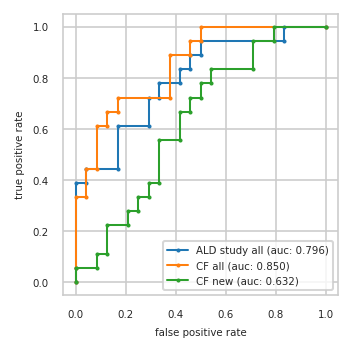

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       CF all       CF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.000 0.056  0.000 0.056  0.000 0.056
2          0.000 0.389  0.000 0.333  0.083 0.056
3          0.042 0.389  0.042 0.333  0.083 0.111
4          0.042 0.444  0.042 0.444  0.125 0.111
5          0.167 0.444  0.083 0.444  0.125 0.222
6          0.167 0.611  0.083 0.611  0.208 0.222
7          0.292 0.611  0.125 0.611  0.208 0.278
8          0.292 0.722  0.125 0.667  0.250 0.278
9          0.333 0.722  0.167 0.667  0.250 0.333
10         0.333 0.778  0.167 0.722  0.292 0.333
11         0.417 0.778  0.375 0.722  0.292 0.389
12         0.417 0.833  0.375 0.889  0.333 0.389
13         0.458 0.833  0.458 0.889  0.333 0.556
14         0.458 0.889  0.458 0.944  0.417 0.556
15         0.500 0.889  0.500 0.944  0.417 0.667
16         0.500 0.944  0.500 1.000  0.458 0.667
17         0.833 0.944  1.000 1.000  0.458 0.722
18         0.833 1.000    NaN   NaN  0.500 0.722
19         1.000 1.000    NaN   NaN  0.500 0.778
20           NaN   NaN    NaN   NaN  0.542 0.778
21           NaN   NaN    NaN   NaN  0.542 0.833
22           NaN   NaN    NaN   NaN  0.708 0.833
23           NaN   NaN    NaN   NaN  0.708 0.944
24           NaN   NaN    NaN   NaN  0.792 0.944
25           NaN   NaN    NaN   NaN  0.792 1.000
26           NaN   NaN    NaN   NaN  1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,CF all,CF new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,Q14165,A6NLU5,P01704
2,P08670,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,Q504Y2
3,B0QYF8;P02144,Q14894,Q96GD0
4,P04075,P61981,P31321
5,P61981,P14174,A0A075B7B8
6,P01597;P04432,Q9Y2T3;Q9Y2T3-3,A6PVN5;F6WIT2;Q15257;Q15257-2;Q15257-3
7,P14174,P04075,A0A0C4DG76;Q5JZ08;Q9BQS7;Q9BQS7-2;Q9BQS7-3;Q9B...
8,A0A0C4DGY8;D6RA00;Q9UHY7,P63104,P51688


### Precision-Recall plot on test data

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf


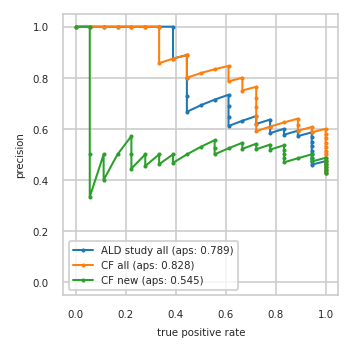

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          CF all          CF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.459 0.944     0.486 1.000     0.486 1.000
6          0.472 0.944     0.500 1.000     0.472 0.944
7          0.486 0.944     0.514 1.000     0.486 0.944
8          0.500 0.944     0.529 1.000     0.500 0.944
9          0.515 0.944     0.545 1.000     0.485 0.889
10         0.531 0.944     0.562 1.000     0.469 0.833
11         0.548 0.944     0.581 1.000     0.484 0.833
12         0.567 0.944     0.600 1.000     0.500 0.833
13         0.586 0.944     0.586 0.944     0.517 0.833
14         0.571 0.889     0.607 0.944     0.536 0.833
15         0.593 0.889     0.593 0.889     0.519 0.778
16         0.577 0.833     0.615 0.889     0.538 0.778
17         0.600 0.833     0.640 0.889     0.520 0.722
18         0.583 0.778     0.625 0.833     0.542 0.722
19         0.609 0.778     0.609 0.778     0.522 0.667
20         0.636 0.778     0.591 0.722     0.545 0.667
21         0.619 0.722     0.619 0.722     0.524 0.611
22         0.650 0.722     0.650 0.722     0.500 0.556
23         0.632 0.667     0.684 0.722     0.526 0.556
24         0.611 0.611     0.722 0.722     0.556 0.556
25         0.647 0.611     0.765 0.722     0.529 0.500
26         0.688 0.611     0.750 0.667     0.500 0.444
27         0.733 0.611     0.800 0.667     0.467 0.389
28         0.714 0.556     0.786 0.611     0.500 0.389
29         0.692 0.500     0.846 0.611     0.462 0.333
30         0.667 0.444     0.833 0.556     0.500 0.333
31         0.727 0.444     0.818 0.500     0.455 0.278
32         0.800 0.444     0.800 0.444     0.500 0.278
33         0.889 0.444     0.889 0.444     0.444 0.222
34         0.875 0.389     0.875 0.389     0.500 0.222
35         1.000 0.389     0.857 0.333     0.571 0.222
36         1.000 0.333     1.000 0.333     0.500 0.167
37         1.000 0.278     1.000 0.278     0.400 0.111
38         1.000 0.222     1.000 0.222     0.500 0.111
39         1.000 0.167     1.000 0.167     0.333 0.056
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf


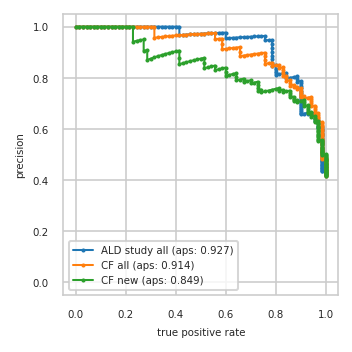

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf


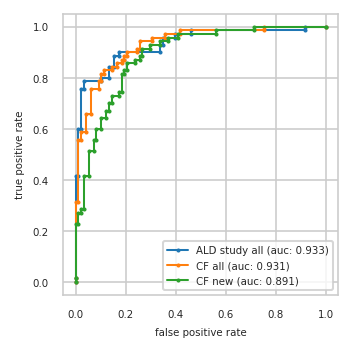

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_CF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF all.pkl'),
 'results_CF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf')}